## Bibliotecas/Funções/Datasets

In [1]:
import os
import sys
import pyet
import xarray as xr
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer


sys.path.append('../src')
from evapo_bibli                  import *

MAIN_PATH = os.path.dirname(os.path.abspath(''))
DATA_PATH = os.path.join(MAIN_PATH, 'data')
CLIMA_PATH = os.path.join(DATA_PATH, '01_raw')
DB_PATH = os.path.join(DATA_PATH, '02_intermediate')

NOTE_PATH = os.path.join(MAIN_PATH, 'notebooks')
CODE_PATH = os.path.join(MAIN_PATH, 'src')

In [2]:
# Função para converter hora para datetime
def converter_hora(hora_str):
    try:
        # Tenta converter para o formato '0000 UTC'
        return pd.to_datetime(hora_str, format='%H%M UTC')
    except ValueError:
        # Se não for possível converter para o formato '0000 UTC', tenta converter para o formato '00:00'
        return pd.to_datetime(hora_str, format='%H:%M')
    
# Função para converter data para datetime
def converter_data(data_str):
    try:
        return pd.to_datetime(data_str, format='%Y/%m/%d')
    except ValueError:
        return pd.to_datetime(data_str, format='%Y-%m-%d')

def determinar_estacao(dia, mes):
    if (mes == 12 and dia >= 22) or (mes == 1) or (mes == 2) or (mes == 3 and dia <= 20):
        return 'Verão'
    elif (mes == 3 and dia > 20) or (mes == 4) or (mes == 5) or (mes == 6 and dia < 21):
        return 'Outono'
    elif (mes == 6 and dia >= 21) or (mes == 7) or (mes == 8) or (mes == 9 and dia < 23):
        return 'Inverno'
    elif (mes == 9 and dia >= 23) or (mes == 10) or (mes == 11) or (mes == 12 and dia < 22):
        return 'Primavera'
    else:
        return 'Data inválida'
     
def ml_error(model_name, y, yhat):
    """Cria um dataframe que traz as metricas MAE, MAPE, RMSE e R2 do modelo treinado

    Args:
        model_name (string): Nome do modelo
        y (_type_): Variavel target 
        yhat (_type_): Variavel target predita

    Returns:
        DataFrame: Dataframe com as métricas de desempenho do modelo
    """
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y,yhat)
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE':rmse,
                         'R2': r2}, index=[0])
    
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i+seq_length]
        sequences.append(sequence)
    return np.array(sequences)

def r_squared(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res/(SS_tot + tf.keras.backend.epsilon())

In [ ]:
df = pd.read_parquet("clima_sp_2011_2020.parquet")

## Tratamento do dataset

In [ ]:
aux = df.copy()

aux['hora'] = aux['hora'].apply(converter_hora)
aux['data'] = aux['data'].apply(converter_data)

aux['data_hora'] = aux['data'] + pd.to_timedelta(aux['hora'].dt.hour, unit='h') + pd.to_timedelta(aux['hora'].dt.minute, unit='m')

aux.drop(columns=['hora', 'data'], inplace=True)
aux.rename(columns={'data_hora': 'data'}, inplace=True)

aux['dia'] = aux['data'].dt.day
aux['mes'] = aux['data'].dt.month
aux['ano'] = aux['data'].dt.year

aux['temperatura_max'] = aux['temperatura_max'].str.replace(',', '.').astype(float)
aux['temperatura_min'] = aux['temperatura_min'].str.replace(',', '.').astype(float)
aux['vento_velocidade'] = aux['vento_velocidade'].str.replace(',', '.').astype(float)
aux['radiacao_global'] = aux['radiacao_global'].str.replace(',', '.').astype(float)
aux['ALTITUDE'] = aux['ALTITUDE'].str.replace(',', '.').astype(float)
aux['LATITUDE'] = aux['LATITUDE'].str.replace(',', '.').astype(float)
aux['LONGITUDE'] = aux['LONGITUDE'].str.replace(',', '.').astype(float)
aux['precipitacao_total'] = aux['precipitacao_total'].str.replace(',', '.').astype(float)
aux['temperatura_ar'] = aux['temperatura_ar'].str.replace(',', '.').astype(float)
aux['pressao_atmosferica'] = aux['pressao_atmosferica'].str.replace(',', '.').astype(float)
aux['pressao_atmosferica_min'] = aux['pressao_atmosferica_min'].str.replace(',', '.').astype(float)
aux['pressao_atmosferica_max'] = aux['pressao_atmosferica_max'].str.replace(',', '.').astype(float)
aux['temperatura_orvalho_max'] = aux['temperatura_orvalho_max'].str.replace(',', '.').astype(float)
aux['temperatura_orvalho_min'] = aux['temperatura_orvalho_min'].str.replace(',', '.').astype(float)
aux['vento_rajada_max'] = aux['vento_rajada_max'].str.replace(',', '.').astype(float)

aux.rename(columns={'REGIÃO': 'regiao', 'UF': 'estado', 'ESTAÇÃO': 'estacao', 'CODIGO (WMO)': 'codigo',
                    'LATITUDE': 'latitude', 'LONGITUDE': 'longitude', 'ALTITUDE': 'altitude',
                    'DATA DE FUNDAÇÃO': 'data_fundacao'},inplace=True)

aux = aux.drop(columns=['undf'])

aux['vento_direcao_rad'] = np.deg2rad(aux['vento_direcao'])
aux['vel_vento_u'] = aux['vento_velocidade'] * np.cos(aux['vento_direcao_rad'])
aux['vel_vento_v'] = aux['vento_velocidade'] * np.sin(aux['vento_direcao_rad'])

aux.to_parquet("clima_sp_2011_2020_trans.parquet")

In [3]:
aux = pd.read_parquet("clima_sp_2011_2020_trans.parquet")

## Ajustando valores nuloes e/ou não físicos e agrupando por dia

In [31]:
aux2 = aux.copy()

aux2 = aux2[aux2['estacao'] != 'CRIOSFERA']

aux2['temperatura_ar'] = aux2['temperatura_ar'].replace(0, np.nan)
aux2['temperatura_ar'] = aux2['temperatura_ar'].mask(aux2['temperatura_ar'] < 0)
aux2['temperatura_min'] = aux2['temperatura_min'].replace(0, np.nan)
aux2['temperatura_min'] = aux2['temperatura_min'].mask(aux2['temperatura_min'] < 0)
aux2['temperatura_max'] = aux2['temperatura_max'].replace(0, np.nan)
aux2['temperatura_max'] = aux2['temperatura_max'].mask(aux2['temperatura_max'] < 0)
aux2['radiacao_global'] = aux2['radiacao_global'].mask(aux2['radiacao_global'] <= 0)
aux2['umidade_rel'] = aux2['umidade_rel'].mask(aux2['umidade_rel'] < 0)
aux2['umidade_rel_max'] = aux2['umidade_rel_max'].mask(aux2['umidade_rel_max'] < 0)
aux2['umidade_rel_min'] = aux2['umidade_rel_min'].mask(aux2['umidade_rel_min'] < 0)
aux2['radiacao_global'] = aux2['radiacao_global'].replace(0, np.nan)
aux2['radiacao_global'] = aux2['radiacao_global'].mask(aux2['radiacao_global'] < 0)
aux2['vento_velocidade'] = aux2['vento_velocidade'].mask(aux2['vento_velocidade'] < 0)
aux2['precipitacao_total'] = aux2['precipitacao_total'].mask(aux2['precipitacao_total'] < 0)
aux2['pressao_atmosferica'] = aux2['pressao_atmosferica'].mask(aux2['pressao_atmosferica'] <= 0)
aux2['pressao_atmosferica_max'] = aux2['pressao_atmosferica_max'].mask(aux2['pressao_atmosferica_max'] <= 0)
aux2['pressao_atmosferica_min'] = aux2['pressao_atmosferica_min'].mask(aux2['pressao_atmosferica_min'] <= 0)

aux2['temperatura_ar'] = aux2['temperatura_ar'].fillna(aux2.groupby(['ano', 'mes', 'dia'])['temperatura_ar'].transform('median'))
aux2['temperatura_max'] = aux2['temperatura_max'].fillna(aux2.groupby(['ano', 'mes', 'dia'])['temperatura_max'].transform('median'))
aux2['temperatura_min'] = aux2['temperatura_min'].fillna(aux2.groupby(['ano', 'mes', 'dia'])['temperatura_min'].transform('median'))
aux2['vento_velocidade'] = aux2['vento_velocidade'].fillna(aux2.groupby(['ano', 'mes', 'dia'])['vento_velocidade'].transform('median'))
aux2['umidade_rel'] = aux2['umidade_rel'].fillna(aux2.groupby(['ano', 'mes', 'dia'])['umidade_rel'].transform('median'))
aux2['umidade_rel_max'] = aux2['umidade_rel_max'].fillna(aux2.groupby(['regiao', 'ano', 'mes', 'dia'])['umidade_rel_max'].transform('median'))
aux2['umidade_rel_min'] = aux2['umidade_rel_min'].fillna(aux2.groupby(['regiao', 'ano', 'mes', 'dia'])['umidade_rel_min'].transform('median'))
aux2['radiacao_global'] = aux2['radiacao_global'].fillna(aux2.groupby(['estacao', 'ano', 'mes'])['radiacao_global'].transform('median'))
aux2['precipitacao_total'] = aux2['precipitacao_total'].fillna(aux2.groupby(['regiao', 'estacao', 'ano', 'mes', 'dia'])['precipitacao_total'].transform('median'))
aux2['radiacao_global'] = aux2['radiacao_global'].fillna(aux2.groupby(['regiao', 'ano', 'mes', 'dia'])['radiacao_global'].transform('median'))
aux2['pressao_atmosferica'] = aux2['pressao_atmosferica'].fillna(aux2.groupby(['regiao', 'ano', 'mes', 'dia'])['pressao_atmosferica'].transform('median'))
aux2['pressao_atmosferica_max'] = aux2['pressao_atmosferica_max'].fillna(aux2.groupby(['regiao', 'estacao', 'ano', 'mes'])['pressao_atmosferica_max'].transform('median'))
aux2['pressao_atmosferica_min'] = aux2['pressao_atmosferica_min'].fillna(aux2.groupby(['regiao', 'estacao', 'ano', 'mes'])['pressao_atmosferica_min'].transform('median'))
aux2['vento_direcao_rad'] = aux2['vento_direcao_rad'].fillna(aux2.groupby(['regiao', 'ano', 'mes', 'dia'])['vento_direcao_rad'].transform('median'))

aux2['vel_vento_u'] = aux2['vento_velocidade'] * np.cos(aux2['vento_direcao_rad'])
aux2['vel_vento_v'] = aux2['vento_velocidade'] * np.sin(aux2['vento_direcao_rad'])

aux2['pressao_atmosferica_kPa'] = aux2['pressao_atmosferica'] / 10
aux2['pressao_atmosferica_max_kPa'] = aux2['pressao_atmosferica_max'] / 10
aux2['pressao_atmosferica_min_kPa'] = aux2['pressao_atmosferica_min'] / 10

aux2 = aux2.groupby(['regiao', 'estado', 'estacao', 'ano', 'mes', 'dia']).agg({
                                              'precipitacao_total': 'sum',
                                              'pressao_atmosferica_kPa': 'mean',
                                              'pressao_atmosferica_max_kPa': 'mean',
                                              'pressao_atmosferica_min_kPa': 'mean',
                                              'radiacao_global': 'sum',
                                              'temperatura_ar': 'mean',
                                              'temperatura_max': 'mean',
                                              'temperatura_min': 'mean',
                                              'temperatura_orvalho_max': 'mean',
                                              'temperatura_orvalho_min': 'mean',
                                              'umidade_rel_max': 'mean',
                                              'umidade_rel_min': 'mean',
                                              'umidade_rel': 'mean',
                                              'vento_direcao_rad': 'mean',
                                              'vento_velocidade': 'mean',
                                              'vel_vento_u': 'mean',
                                              'vel_vento_v': 'mean',
                                              'vento_rajada_max': 'mean',
                                              'latitude': 'median',
                                              'longitude': 'median',
                                              'altitude': 'median',}).reset_index()

aux2['radiacao_global'] = aux2['radiacao_global']/1000/12

aux2['data'] = pd.to_datetime(aux2['ano'].astype(str) + '-' + aux2['mes'].astype(str) + '-' + aux2['dia'].astype(str))

aux2['lat_rad'] = np.deg2rad(aux2['latitude'])
aux2['lon_rad'] = np.deg2rad(aux2['longitude'])

aux2.set_index('data', inplace=True)

## Calculo da evapotranspiração de Penman-Monteith

In [37]:
clima = aux2[['temperatura_max', 'temperatura_min', 'temperatura_ar', 'umidade_rel', 'umidade_rel_max', 'umidade_rel_min', 'pressao_atmosferica_kPa', 'radiacao_global', 'vento_velocidade', 'lat_rad', 'altitude']]

tmax, tmin, tmean, rh, rh_max, rh_min, pressure, rs, wind, lat, elev = [clima[column] for column in clima.columns]

aux2['ET0_fao'] = pyet.pm_fao56(tmean, wind, tmax=tmax, rs=rs, tmin=tmin, rh=rh, rhmax=rh_max, rhmin=rh_min, pressure=pressure, elevation=elev, lat=lat)

## Modelo de predição de ET0

In [ ]:
#aux3 = aux2
aux3 = aux2[['ESTAÇÃO', 'ALTITUDE', 'lat_rad', 'lon_rad', 'temperatura_min', 'temperatura_max', 'temperatura_media', 'radiacao_global', 'umidade_rel', 'precipitacao_total', 'vento_velocidade', 'ET0_fao']]

In [47]:
aux3 = aux2[['estacao', 'mes', 'dia', 'altitude', 'lat_rad', 'lon_rad', 'temperatura_ar', 'vel_vento_u', 'vel_vento_v', 'umidade_rel', 'ET0_fao']].copy()

#aux3['estacao_ano'] = aux3.apply(lambda row: determinar_estacao(row['dia'], row['mes']), axis=1)

#aux3 = pd.get_dummies(aux3, columns=['estacao_ano'], dtype=int)

#aux3 = aux3.drop(columns=['mes', 'dia'])

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Inicialize o MinMaxScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_treino = aux3[aux3.index.year < 2020].drop(columns=['ET0_fao'], errors='ignore')
y_treino = aux3[aux3.index.year < 2020]['ET0_fao']

X_val = aux3[(aux3.index.year == 2020) | (aux3.index.year == 2021) | (aux3.index.year == 2022)].drop(columns=['ET0_fao'],errors='ignore')
y_val = aux3[(aux3.index.year == 2020) | (aux3.index.year == 2021) | (aux3.index.year == 2022)]['ET0_fao']

timesteps = 365

# Extraindo a coluna 'ESTAÇÕES' para uso posterior
estacoes_treino = X_treino['estacao']
estacoes_val = X_val['estacao']

# Ajuste o scaler aos dados de treino e transforme-os
X_treino_scaled = scaler_X.fit_transform(X_treino.drop(columns=['estacao'], errors='ignore'))
y_treino_scaled = scaler_y.fit_transform(y_treino.values.reshape(-1, 1)).flatten()

# Transforme os dados de validação usando os scalers ajustados aos dados de treino
X_val_scaled = scaler_X.transform(X_val.drop(columns=['estacao'], errors='ignore'))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()

# Criar sequências para os dados de treino e validação
X_treino_sequences = create_sequences(X_treino_scaled, timesteps)
y_treino_sequences = y_treino_scaled[timesteps-1:]

X_val_sequences = create_sequences(X_val_scaled, timesteps)
y_val_sequences = y_val_scaled[timesteps-1:]

## RNNs

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

# Definindo os parâmetros do modelo
input_dim = 9  # Dimensão da entrada (número de features)
hidden_units = 64  # Número de unidades ocultas na camada RNN
output_dim = 1  # Dimensão da saída (regressão univariada)

# Criando o modelo RNN
model = Sequential([
        LSTM(hidden_units, input_shape=(None, input_dim)),
        #Dense(64, activation='relu'),  # Segunda camada oculta com 15 neurônios
        Dense(output_dim)
])
# Compilando o modelo
model.compile(optimizer='adam', loss='mse', metrics=[r_squared, tf.keras.metrics.RootMeanSquaredError(name='rmse')])

# Exibindo um resumo do modelo
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                18944     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19009 (74.25 KB)
Trainable params: 19009 (74.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
model.fit(X_treino_sequences, y_treino_sequences, epochs=7, validation_data=(X_val_sequences, y_val_sequences))

Epoch 1/7
3469/3469 [==============================] - 258s 74ms/step - loss: 0.0802 - r_squared: 0.9104 - rmse: 0.2832 - val_loss: 0.1946 - val_r_squared: 0.2883 - val_rmse: 0.4412
Epoch 2/7
3469/3469 [==============================] - 265s 76ms/step - loss: 0.0669 - r_squared: 0.9254 - rmse: 0.2586 - val_loss: 0.2028 - val_r_squared: 0.2223 - val_rmse: 0.4503
Epoch 3/7
3469/3469 [==============================] - 269s 78ms/step - loss: 0.0646 - r_squared: 0.9276 - rmse: 0.2542 - val_loss: 0.1964 - val_r_squared: 0.2867 - val_rmse: 0.4432
Epoch 4/7
3469/3469 [==============================] - 262s 76ms/step - loss: 0.0645 - r_squared: 0.9278 - rmse: 0.2540 - val_loss: 0.2108 - val_r_squared: 0.2238 - val_rmse: 0.4592
Epoch 5/7
3469/3469 [==============================] - 258s 74ms/step - loss: 0.0576 - r_squared: 0.9355 - rmse: 0.2400 - val_loss: 0.1965 - val_r_squared: 0.2624 - val_rmse: 0.4432
Epoch 6/7
3469/3469 [==============================] - 256s 74ms/step - loss: 0.0533 - r_s

In [46]:
df_val

,estacao,mes,dia,altitude,lat_rad,lon_rad,temperatura_ar,vel_vento_u,vel_vento_v,umidade_rel,ET0_fao
data,,,,,,,,,,,
2020-01-01,ARIRANHA,1,1,525.44,-0.368841,-0.852429,25.100000,-1.389565,-0.170617,71.000000,1.884146
2020-01-02,ARIRANHA,1,2,525.44,-0.368841,-0.852429,23.400000,-1.124007,-0.420249,83.000000,1.348148
2020-01-03,ARIRANHA,1,3,525.44,-0.368841,-0.852429,22.400000,-1.662983,0.688830,87.500000,1.310976
2020-01-04,ARIRANHA,1,4,525.44,-0.368841,-0.852429,22.300000,-1.552473,0.387075,81.000000,1.512091
2020-01-05,ARIRANHA,1,5,525.44,-0.368841,-0.852429,21.900000,-1.455444,0.362883,86.000000,1.305405
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,VOTUPORANGA,12,27,510.37,-0.356103,-0.872072,23.250000,0.813894,0.236608,83.083333,1.163374
2020-12-28,VOTUPORANGA,12,28,510.37,-0.356103,-0.872072,23.662500,0.669263,-0.028035,80.916667,1.347843
2020-12-29,VOTUPORANGA,12,29,510.37,-0.356103,-0.872072,24.670833,0.704707,-0.151005,78.750000,1.436287


1382/1382 [==============================] - 41s 29ms/step


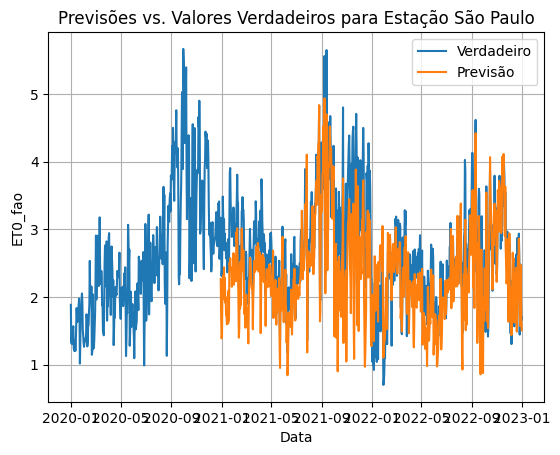

In [48]:
# 1. Fazer previsões com o modelo treinado
y_pred_scaled = model.predict(X_val_sequences)

# 2. Transformar as previsões de volta para a escala original
y_pred_original_scale = scaler_y.inverse_transform(y_pred_scaled).flatten()

# Converter as previsões de volta para o DataFrame original
df_pred = pd.DataFrame({'ET0_fao_pred': y_pred_original_scale}, index=y_val.index[timesteps-1:])

# Adicionar a coluna 'estacao' de volta aos dados de validação e previsões
df_val = pd.concat([X_val, pd.DataFrame({'ET0_fao': y_val}, index=X_val.index)], axis=1)
df_pred['estacao'] = estacoes_val[364:].values

# Filtrar os dados apenas para a estação 'SaoPaulo'
df_val_sao_paulo = df_val[df_val['estacao'] == 'ARIRANHA']
df_pred_sao_paulo = df_pred[df_pred['estacao'] == 'ARIRANHA']

# Plotar os resultados
plt.plot(df_val_sao_paulo.index, df_val_sao_paulo['ET0_fao'], label='Verdadeiro')
plt.plot(df_pred_sao_paulo.index, df_pred_sao_paulo['ET0_fao_pred'], label='Previsão')

plt.xlabel('Data')
plt.ylabel('ET0_fao')
plt.title('Previsões vs. Valores Verdadeiros para Estação São Paulo')
plt.legend()
plt.grid()
plt.show()


In [55]:
df_pred_sao_paulo

,ET0_fao_pred,estacao
data,,
2020-12-30,2.268332,ARIRANHA
2020-12-31,1.716956,ARIRANHA
2021-01-01,1.388327,ARIRANHA
2021-01-02,1.429088,ARIRANHA
2021-01-03,2.027687,ARIRANHA
...,...,...
2022-12-27,1.573202,ARIRANHA
2022-12-28,2.472109,ARIRANHA
2022-12-29,2.192625,ARIRANHA


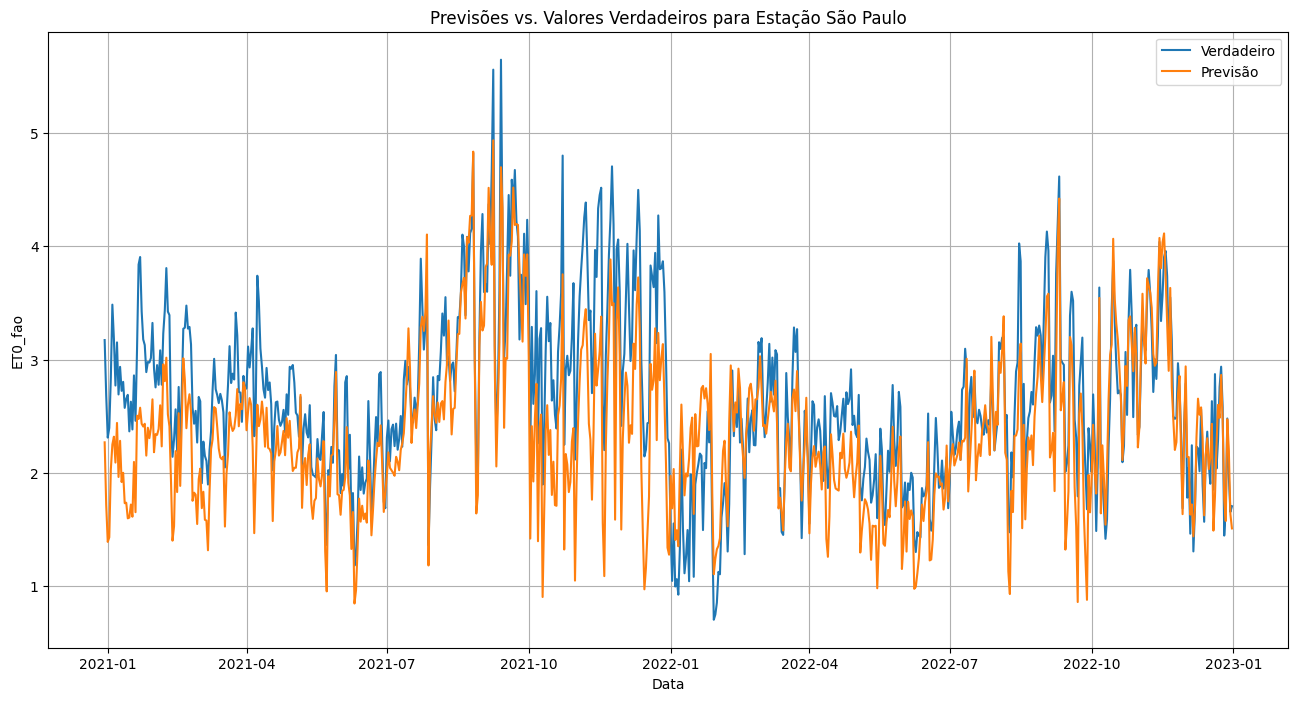

In [62]:
plt.figure(figsize=(16, 8))
plt.plot(df_val_sao_paulo.index[df_val_sao_paulo.index >= '2020-12-30'], df_val_sao_paulo[df_val_sao_paulo.index >= '2020-12-30']['ET0_fao'], label='Verdadeiro')
plt.plot(df_pred_sao_paulo.index, df_pred_sao_paulo['ET0_fao_pred'], label='Previsão')

plt.xlabel('Data')
plt.ylabel('ET0_fao')
plt.title('Previsões vs. Valores Verdadeiros para Estação São Paulo')
plt.legend()
plt.grid()
plt.show()


In [45]:
df_val[df_val['estacao'] == 'ARIRANHA']

,estacao,mes,dia,altitude,lat_rad,lon_rad,temperatura_ar,vel_vento_u,vel_vento_v,umidade_rel,ET0_fao
data,,,,,,,,,,,
2020-01-01,ARIRANHA,1,1,525.44,-0.368841,-0.852429,25.100000,-1.389565,-0.170617,71.000000,1.884146
2020-01-02,ARIRANHA,1,2,525.44,-0.368841,-0.852429,23.400000,-1.124007,-0.420249,83.000000,1.348148
2020-01-03,ARIRANHA,1,3,525.44,-0.368841,-0.852429,22.400000,-1.662983,0.688830,87.500000,1.310976
2020-01-04,ARIRANHA,1,4,525.44,-0.368841,-0.852429,22.300000,-1.552473,0.387075,81.000000,1.512091
2020-01-05,ARIRANHA,1,5,525.44,-0.368841,-0.852429,21.900000,-1.455444,0.362883,86.000000,1.305405
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,ARIRANHA,12,27,525.44,-0.368841,-0.852429,22.820833,-0.573185,0.423515,82.625000,2.564793
2020-12-28,ARIRANHA,12,28,525.44,-0.368841,-0.852429,23.558333,-0.632383,-0.582167,79.083333,2.714999
2020-12-29,ARIRANHA,12,29,525.44,-0.368841,-0.852429,25.208333,-0.742473,-1.021714,76.208333,3.009249


In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = aux3.drop(columns=['ESTAÇÃO']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')

## MLP


In [ ]:
aux3 = aux2[['estacao', 'dia', 'mes', 'temperatura_ar', 'ET0_fao']]

aux3['estacao_ano'] = aux3.apply(lambda row: determinar_estacao(row['dia'], row['mes']), axis=1)

aux3 = aux3[aux3['estacao_ano'] == 'Outono'].drop(columns=['dia', 'mes', 'estacao_ano'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Inicialize o MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

X_treino = aux3[aux3.index.year < 2023].drop(columns=['ET0_fao'], errors='ignore')
y_treino = aux3[aux3.index.year < 2023]['ET0_fao']

X_val = aux3[aux3.index.year == 2023].drop(columns=['ET0_fao'],errors='ignore')
y_val = aux3[aux3.index.year == 2023]['ET0_fao']

timesteps = 365

# Extraindo a coluna 'ESTAÇÕES' para uso posterior
estacoes_treino = X_treino['estacao']
estacoes_val = X_val['estacao']

# Removendo a coluna 'ESTAÇÕES' dos dados
#X_treino = X_treino.drop(columns=['estacao'], errors='ignore')
#X_val = X_val.drop(columns=['estacao'], errors='ignore')

# Ajuste o scaler aos dados de treino e transforme-os
X_treino_scaled = scaler_X.fit_transform(X_treino.drop(columns=['estacao'], errors='ignore'))
y_treino_scaled = scaler_y.fit_transform(y_treino.values.reshape(-1, 1)).flatten()

# Transforme os dados de validação usando os scalers ajustados aos dados de treino
X_val_scaled = scaler_X.transform(X_val.drop(columns=['estacao'], errors='ignore'))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()

# Criar sequências para os dados de treino e validação
X_treino_sequences = create_sequences(X_treino_scaled, timesteps)
y_treino_sequences = y_treino_scaled[timesteps-1:]

X_val_sequences = create_sequences(X_val_scaled, timesteps)
y_val_sequences = y_val_scaled[timesteps-1:]

# Agora, você tem os dados de treino e validação sem a coluna 'ESTAÇÕES', 
# mas você ainda tem as variáveis estacoes_treino e estacoes_val que 
# contêm as estações correspondentes aos dados de treino e validação, 
# respectivamente.


In [ ]:
import tensorflow as tf

# Definir a arquitetura da rede neural
model = tf.keras.Sequential([
    tf.keras.layers.Dense(15, activation='relu', input_shape=(1,)),  # Primeira camada oculta com 15 neurônios
    tf.keras.layers.Dense(5, activation='relu'),  # Segunda camada oculta com 15 neurônios
    tf.keras.layers.Dense(1)  # Camada de saída com um neurônio
])

# Compilar o modelo
#model.compile(optimizer='adam', loss='mse')  # Utilizando Adam como otimizador e erro quadrático médio como função de perda
model.compile(optimizer='RMSProp', loss='mse', metrics=[r_squared, tf.keras.metrics.RootMeanSquaredError(name='rmse')])

# Treinar o modelo - supondo que você tenha os dados de entrada e saída
# X_train é uma matriz contendo os valores da temperatura do ar
# y_train é uma matriz contendo os valores da evapotranspiração correspondentes
model.fit(X_treino.drop(columns=['estacao']), y_treino, epochs=1000, batch_size=32, validation_data=(X_val.drop(columns=['estacao']), y_val))  # Por exemplo, treinando por 100 épocas com um tamanho de lote de 32

# Avaliar o modelo, se necessário
# model.evaluate(X_test, y_test)


## Brincando com Xarrays

In [ ]:
#Mantem a data como index e adiciona as colunas LATITUDE, LONGITUDE e ALTITUDE como index
aux3 = aux2.copy()

aux3['data'] = aux2.index
aux3 = aux3.set_index(['data', 'LATITUDE', 'LONGITUDE'])


In [ ]:
aux4 = aux3.to_xarray()

In [ ]:
temp_media_global = aux4['ET0_fao'].mean(dim=('LATITUDE', 'LONGITUDE'))

In [ ]:
temp_media_global.plot()